# Attribute selection with information gain
### Case workbook

Source: [F. Provost, T. Fawcett, "Data Science for Business"](https://data-science-for-biz.com/)
Dataset source: [Mushroom Data Set](https://archive.ics.uci.edu/ml/datasets/Mushroom)

Problem outline: having a dataset with instances described by attributes and target variable, determine which attribute is the most informative with respect to estimating the value of target variable. 

Problem type: classification

Dataset values: categorical

Target variable: edible (e), poisonous (p)

Splitting criterion: [Informastion gain](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees)


<img src="https://images.pexels.com/photos/3100522/pexels-photo-3100522.jpeg?cs=srgb&dl=pexels-katalin-rhorv%C3%A1t-3100522.jpg&fm=jpg" width="600" height="400"></img>
<br>
_Photo by Katalin RHorvát from Pexels_



In [4]:
## IMPORT SECTION ##
####################

## Data utils

import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import entropy

## Other

from pathlib import Path

In [5]:
## Read dataset ##
##################

mushroom_set = pd.read_csv('./data/mushrooms.csv')
mushroom_set.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [6]:
## Functions ##
###############

def weight_values(df):
    '''
    Constructs a dataframe containing normalized value counts for each 
    input dataframe's attribute.
    :df: pd.DataFrame
    :return: pd.DataFrame
    '''
    
    output = pd.DataFrame()

    for col in df.columns:
        coldf = pd.DataFrame()

        ## Get relative counts of values
        coldf[col] = df[col].value_counts(normalize=True)

        ## Construct hierarchical index on coldf
        coldf = pd.concat([coldf], keys=[col], names=['attribute','value'])
        
        coldf.rename(columns={col:'val_weights'}, inplace = True)
        
        ## Concat to output dataframe
        output = pd.concat([output, coldf])
    

    return output


def weight_segments(s_df, w_df, l_name = 'class'):
    '''
    Performs a segmentation of categorical attributes and calculates label weights for each attribute's value.
    :s_df: source dataframe pd.DataFrame()
    :w_df: dataframe containing value weights for each attribute pd.DataFrame()
    :l_name: label name str
    :return: pd.DataFrame() 
    '''
    
    class_w_df = pd.DataFrame()
    
    ## Perform segmentation
    ## For each attribute in weight dataframe
    for attribute in w_df.index.levels[0]:
        
            ## For each value in weight dataframe
            for val in w_df.loc[attribute].index:
                
                ## Calculate label weights
                col_class_weights = s_df.loc[s_df[attribute]==val][l_name].value_counts(normalize=True)
                ## Cast pd.Series into pd.DataFrame
                col_class_weights = pd.DataFrame(col_class_weights)
                ## Transpose pd.DataFrame
                col_class_weights = col_class_weights.T
                ## Set categorical values as index
                col_class_weights['value'] = val
                col_class_weights.set_index('value',inplace=True)
                ## Construct hierarchical index
                col_class_weights = pd.concat([col_class_weights], keys=[attribute, val], names=['attribute','value'])
                ## Join pd.DataFrame to output pd.Dataframe
                class_w_df = pd.concat([class_w_df,col_class_weights])

    return class_w_df

In [7]:
## Construct sub dataframes
weight_df = weight_values(mushroom_set)
segmented_df = weight_segments(mushroom_set, weight_df)

## Construct dataframe for entropy calculation
entropy_df = segmented_df.join(weight_df)
entropy_df.fillna(0, inplace = True)
entropy_df

p         e  val_weights
attribute  value                                 
bruises    f      0.693345  0.306655     0.584441
           t      0.184834  0.815166     0.415559
cap-color  n      0.446585  0.553415     0.281142
           g      0.439130  0.560870     0.226489
           e      0.584000  0.416000     0.184638
...                    ...       ...          ...
veil-color w      0.493185  0.506815     0.975382
           o      0.000000  1.000000     0.011817
           n      0.000000  1.000000     0.011817
           y      1.000000  0.000000     0.000985
veil-type  p      0.482029  0.517971     1.000000

[119 rows x 3 columns]

In [8]:
## Calculate parent entropy parameter
parent_entropy = entropy(
    [entropy_df.loc[('class','p')]['val_weights'], 
     entropy_df.loc[('class','e')]['val_weights']],
    base=2
    )

In [9]:
## Calculate normalized entropy for each value in the segment
entropy_df['segment_entropy'] =  entropy([entropy_df['p'], entropy_df['e']], base=2)
entropy_df['weighted_entropy'] = entropy_df['val_weights'] * entropy_df['segment_entropy']
entropy_df

p         e  val_weights  segment_entropy  \
attribute  value                                                     
bruises    f      0.693345  0.306655     0.584441         0.889275   
           t      0.184834  0.815166     0.415559         0.690539   
cap-color  n      0.446585  0.553415     0.281142         0.991752   
           g      0.439130  0.560870     0.226489         0.989283   
           e      0.584000  0.416000     0.184638         0.979544   
...                    ...       ...          ...              ...   
veil-color w      0.493185  0.506815     0.975382         0.999866   
           o      0.000000  1.000000     0.011817         0.000000   
           n      0.000000  1.000000     0.011817         0.000000   
           y      1.000000  0.000000     0.000985         0.000000   
veil-type  p      0.482029  0.517971     1.000000         0.999068   

                  weighted_entropy  
attribute  value                    
bruises    f              0.519729  
           t              0.286960  
cap-color  n              0.278823  
           g              0.224062  
           e              0.180861  
...                            ...  
veil-color w              0.975251  
           o              0.000000  
           n              0.000000  
           y              0.000000  
veil-type  p              0.999068  

[119 rows x 5 columns]

In [10]:
## Construct a list of attribute, information gain tuples
ig_list = [(attribute, parent_entropy - entropy_df.loc[attribute]['weighted_entropy'].sum()) # calculate information gain
           for attribute 
           in entropy_df.index.levels[0] 
           if len(entropy_df.loc[attribute]) > 1 and attribute != 'class'] # exclude segments with one item and labels

In [11]:
## Construct information gain dataframe
ig_df = pd.DataFrame(ig_list,
            columns=['Attribute', 'Information Gain'])

ig_df.set_index('Attribute', inplace = True)
ig_df

,Information Gain
Attribute,
bruises,0.192379
cap-color,0.036049
cap-shape,0.048797
cap-surface,0.028590
gill-attachment,0.014165
gill-color,0.416978
gill-size,0.230154
gill-spacing,0.100883
habitat,0.156834


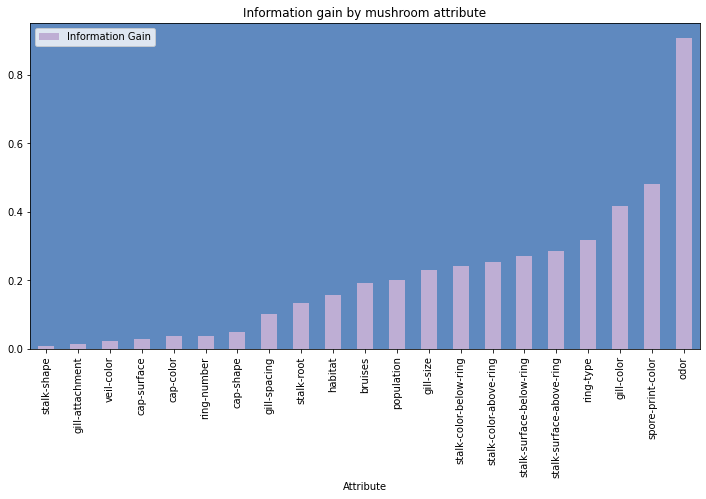

In [15]:
## Visualize results

%matplotlib inline

_ = ig_df.sort_values(by = 'Information Gain').plot(kind='bar', title='Information gain by mushroom attribute', color='#beaed4', figsize=[12,6])
_.patch.set_facecolor('#386cb0')
_.patch.set_alpha(0.8)